In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

import ROOT
from ROOT import TFile, TH1F, TCanvas, TMath,TLine, TH1, TLegend
import copy
import array
ROOT.gStyle.SetOptStat(0)
ROOT.disableJSVis()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetBarWidth(1);
ROOT.gStyle.SetHistLineWidth(1);
import sys
sys.path.append("/eos/home-x/xuyan/TrijetProj/TrijetAna_Main/ZprimeAna/utiles")
from CMSStyle import CMS_lumi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

plt.rcParams['figure.figsize'] = (12, 10)  # Set the default figure size
plt.rcParams['legend.fontsize'] = 20  # Set the default font size for legends
plt.rcParams['axes.labelsize'] = 14  # Set the default font size for axis labels (x and y)
plt.rcParams['axes.titlesize'] = 16  # Set the default font size for the plot title
plt.rcParams['xtick.labelsize'] = 12  # Set the default font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 12  # Set the default font size for y-tick labels
plt.rcParams['lines.linewidth'] = 1.5  # Set the default line width
plt.rcParams['lines.markersize'] = 8  # Set the default marker size

Welcome to JupyROOT 6.30/02


2024-02-07 16:56:02.416471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
flat_tree = uproot.open("Tree_BuToKEE_presel_lowq2.root")['Events']
df_KEE = flat_tree.arrays(library='pd')
flat_tree = uproot.open("Tree_BdToK0starEE_presel_lowq2.root")['Events']
df_K0StarEE = flat_tree.arrays(library='pd')

num_rows, num_columns = df_KEE.shape
df_KEE["label"] = np.ones(num_rows)
num_rows, num_columns = df_K0StarEE.shape
df_K0StarEE["label"] = np.zeros(num_rows)

df = pd.concat([df_KEE, df_K0StarEE], axis = 0)
# print(df)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

X = df.drop(columns=["label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

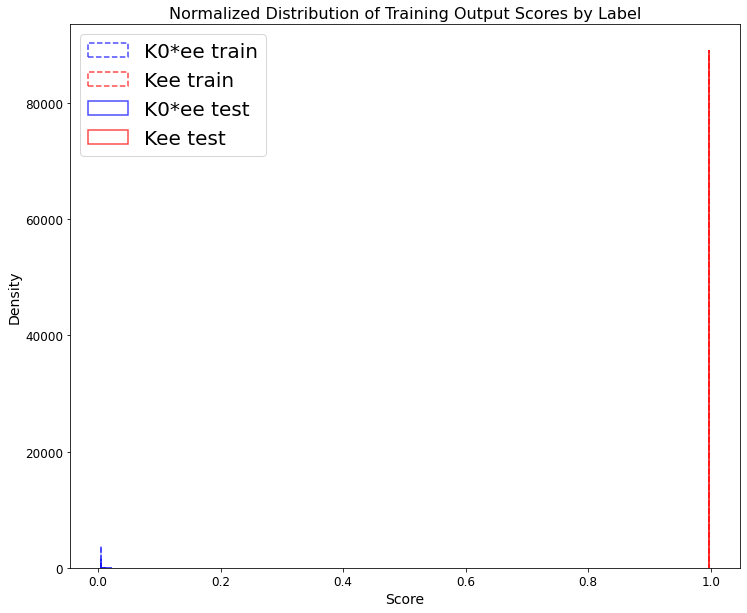

In [3]:
# Define the DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

# Train the model
num_round = 50
bst = xgb.train(params, dtrain, num_round)

# Make predictions on train set
train_scores = bst.predict(dtrain, output_margin=False)

# Convert the DMatrix back to DataFrame
df_train = pd.DataFrame(dtrain.get_label(), columns=['label'])
df_train['score'] = train_scores

# Segment scores based on label
train_scores_label_0 = df_train[df_train['label'] == 0]['score']
train_scores_label_1 = df_train[df_train['label'] == 1]['score']

# Make predictions on test set
test_scores = bst.predict(dtest, output_margin=False)

# Convert the DMatrix back to DataFrame
df_test = pd.DataFrame(dtest.get_label(), columns=['label'])
df_test['score'] = test_scores

# Segment scores based on label
test_scores_label_0 = df_test[df_test['label'] == 0]['score']
test_scores_label_1 = df_test[df_test['label'] == 1]['score']

# Plotting distributions
plt.figure(figsize=(12, 10))
plt.hist(train_scores_label_0, bins=30, density=True, alpha=0.7, label='K0*ee train', 
         edgecolor='blue', linewidth=1.5, linestyle='dashed',facecolor='none',histtype='stepfilled')
plt.hist(train_scores_label_1, bins=30, density=True, alpha=0.7, label='Kee train', 
         edgecolor='red', linewidth=1.5, linestyle='dashed', facecolor='none',histtype='stepfilled')
plt.hist(test_scores_label_0, bins=30, density=True, alpha=0.7, label='K0*ee test', 
         edgecolor='blue', linewidth=1.5, facecolor='none',histtype='stepfilled')
plt.hist(test_scores_label_1, bins=30, density=True, alpha=0.7, label='Kee test', 
         edgecolor='red', linewidth=1.5, facecolor='none',histtype='stepfilled')

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Normalized Distribution of Training Output Scores by Label')
plt.legend()
plt.show()

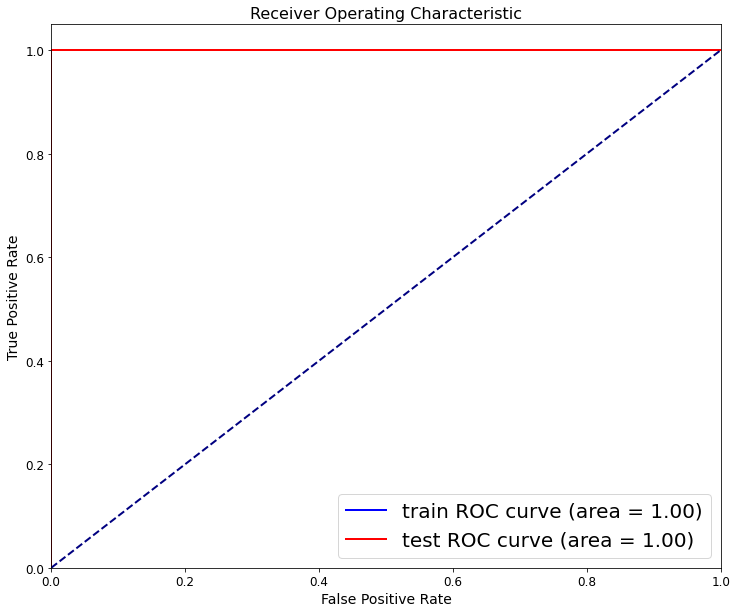

/tmp/ipykernel_532/71818591.py:29: RuntimeWarning: divide by zero encountered in divide
  sig = np.array(sig_num/np.sqrt(sig_den) / (len(test_scores_label_1) / ROOT.TMath.Sqrt(len(test_scores_label_0))))


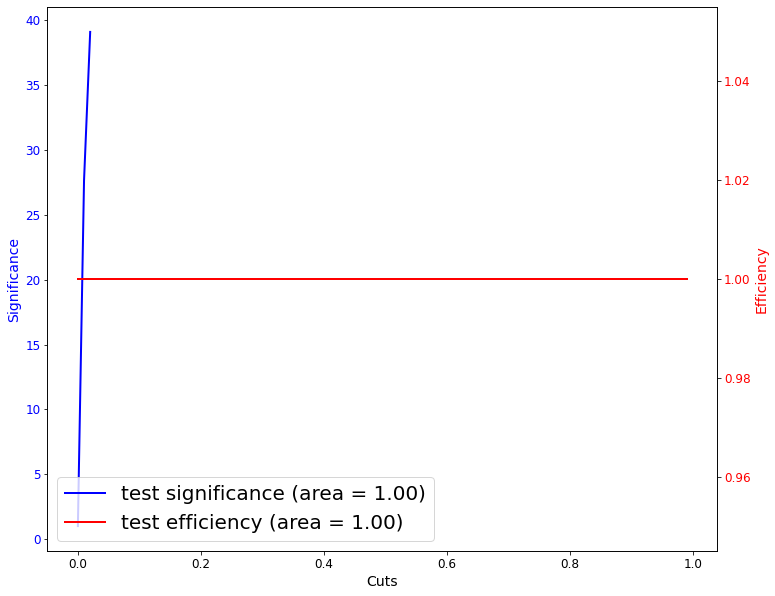

In [4]:
# Concatenate the scores from both classes and the true labels
train_scores = np.concatenate([train_scores_label_0, train_scores_label_1])
train_labels = np.concatenate([np.zeros(len(train_scores_label_0)), np.ones(len(train_scores_label_1))])
test_scores = np.concatenate([test_scores_label_0, test_scores_label_1])
test_labels = np.concatenate([np.zeros(len(test_scores_label_0)), np.ones(len(test_scores_label_1))])

# Compute ROC curve and ROC area
train_fpr, train_tpr, _ = roc_curve(train_labels, train_scores)
train_roc_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, _ = roc_curve(test_labels, test_scores)
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='train ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot(test_fpr, test_tpr, color='red', lw=2, label='test ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cuts = np.arange(0, 1, 0.01)
sig_num = [np.sum(np.sort(test_scores_label_1) > value) for value in cuts] 
sig_den = [np.sum(np.sort(test_scores_label_0) > value) for value in cuts] 
sig = np.array(sig_num/np.sqrt(sig_den) / (len(test_scores_label_1) / ROOT.TMath.Sqrt(len(test_scores_label_0))))
eff = np.array(sig_num) / float(len(test_scores_label_1))

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the first curve on ax1
ax1.plot(cuts, sig, color='blue', lw=2, label='test significance (area = %0.2f)' % 1)
ax1.set_xlabel('Cuts')
ax1.set_ylabel('Significance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create ax2 that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot the second curve on ax2
ax2.plot(cuts, eff, color='red', lw=2, label='test efficiency (area = %0.2f)' % 1)
ax2.set_ylabel('Efficiency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend with a combined list of handles from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# Show the plot
plt.show()

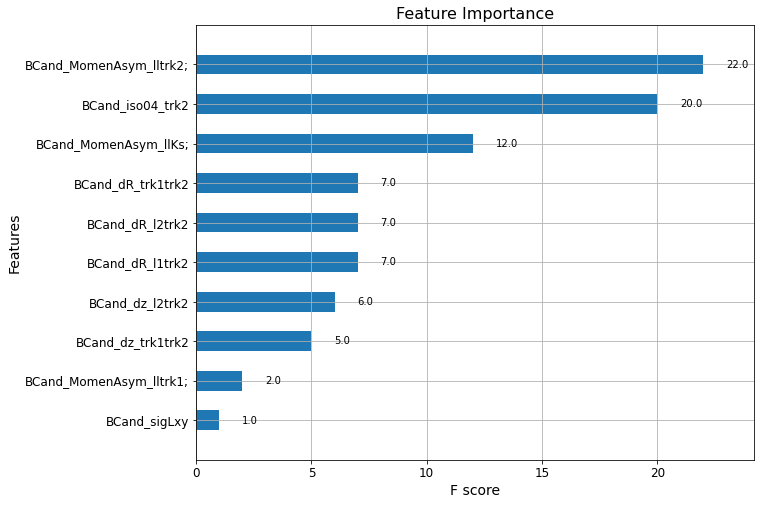

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = xgb.plot_importance(bst,ax=ax,height=0.5)
plt.title('Feature Importance')
plt.show()

In [79]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1251/1251 [==============================] - 4s 2ms/step - loss: 0.5629 - accuracy: 0.7478 - val_loss: 0.5345 - val_accuracy: 0.7541
Epoch 2/10
1251/1251 [==============================] - 2s 2ms/step - loss: 0.5278 - accuracy: 0.7538 - val_loss: 0.5365 - val_accuracy: 0.7445
Epoch 3/10
1251/1251 [==============================] - 2s 2ms/step - loss: 0.5213 - accuracy: 0.7543 - val_loss: 0.5175 - val_accuracy: 0.7549
Epoch 4/10
1251/1251 [==============================] - 3s 2ms/step - loss: 0.5185 - accuracy: 0.7554 - val_loss: 0.5136 - val_accuracy: 0.7556
Epoch 5/10
1251/1251 [==============================] - 2s 2ms/step - loss: 0.5150 - accuracy: 0.7566 - val_loss: 0.5095 - val_accuracy: 0.7572
Epoch 6/10
1251/1251 [==============================] - 2s 2ms/step - loss: 0.5127 - accuracy: 0.7570 - val_loss: 0.5165 - val_accuracy: 0.7548
Epoch 7/10
1251/1251 [==============================] - 2s 2ms/step - loss: 0.5098 - accuracy: 0.7588 - val_loss: 0.5075 - val_accuracy:

1251/1251 [==============================] - 1s 1ms/step


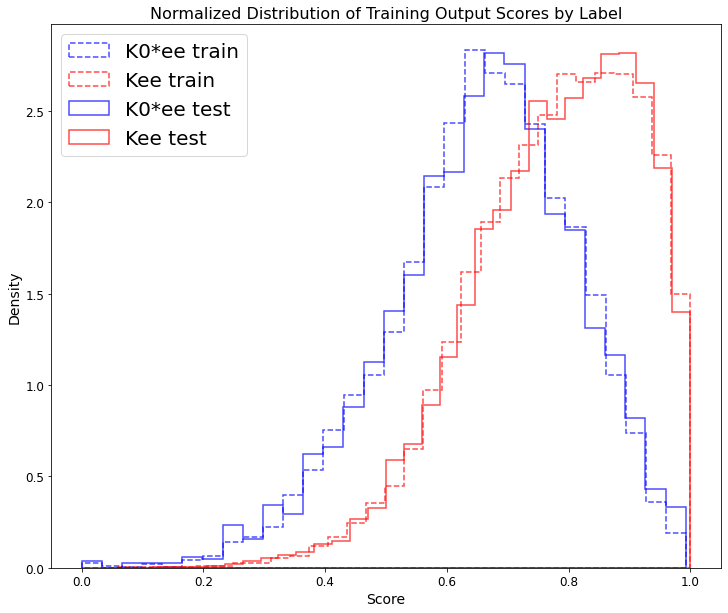

In [80]:
test_predicted_scores = model.predict(X_test)
train_predicted_scores = model.predict(X_train)
# Separate the scores based on the actual labels
train_scores_label_0 = train_predicted_scores[y_train == 0]
train_scores_label_1 = train_predicted_scores[y_train == 1]
test_scores_label_0 = test_predicted_scores[y_test == 0]
test_scores_label_1 = test_predicted_scores[y_test == 1]

# Plotting
plt.figure(figsize=(12, 10))
plt.hist(train_scores_label_0, bins=30, density=True, alpha=0.7, label='K0*ee train', 
         edgecolor='blue', linewidth=1.5, linestyle='dashed',facecolor='none',histtype='stepfilled')
plt.hist(train_scores_label_1, bins=30, density=True, alpha=0.7, label='Kee train', 
         edgecolor='red', linewidth=1.5, linestyle='dashed', facecolor='none',histtype='stepfilled')
plt.hist(test_scores_label_0, bins=30, density=True, alpha=0.7, label='K0*ee test', 
         edgecolor='blue', linewidth=1.5, facecolor='none',histtype='stepfilled')
plt.hist(test_scores_label_1, bins=30, density=True, alpha=0.7, label='Kee test', 
         edgecolor='red', linewidth=1.5, facecolor='none',histtype='stepfilled')

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Normalized Distribution of Training Output Scores by Label')
plt.legend()
plt.show()

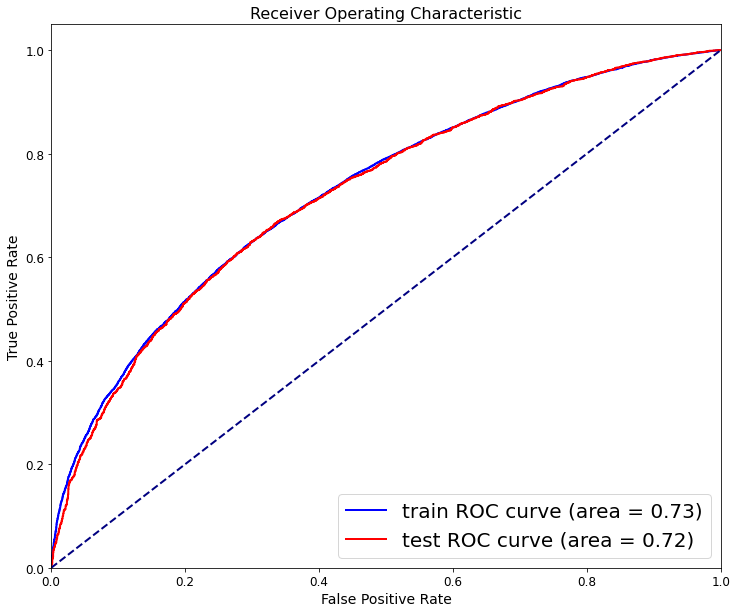

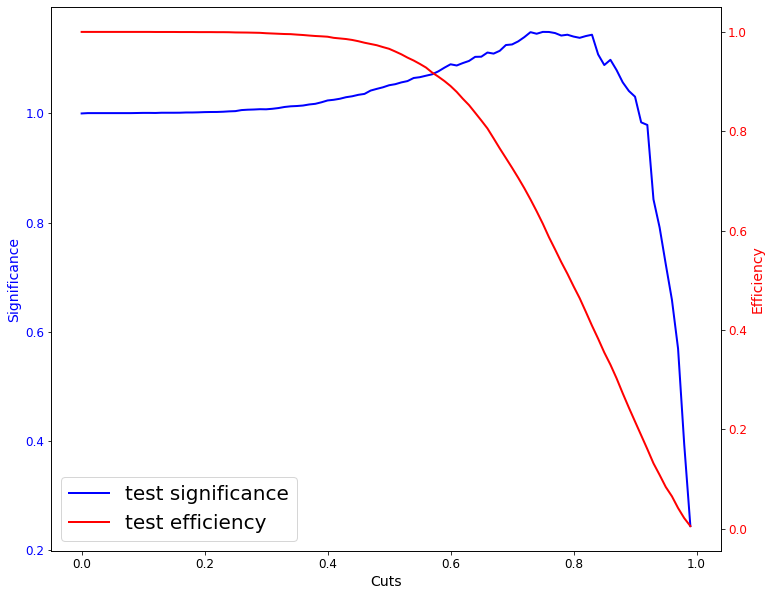

In [81]:
# Concatenate the scores from both classes and the true labels
train_scores = np.concatenate([train_scores_label_0, train_scores_label_1])
train_labels = np.concatenate([np.zeros(len(train_scores_label_0)), np.ones(len(train_scores_label_1))])
test_scores = np.concatenate([test_scores_label_0, test_scores_label_1])
test_labels = np.concatenate([np.zeros(len(test_scores_label_0)), np.ones(len(test_scores_label_1))])

# Compute ROC curve and ROC area
train_fpr, train_tpr, _ = roc_curve(train_labels, train_scores)
train_roc_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, _ = roc_curve(test_labels, test_scores)
test_roc_auc = auc(test_fpr, test_tpr)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='train ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot(test_fpr, test_tpr, color='red', lw=2, label='test ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

cuts = np.arange(0, 1, 0.01)
sig_num = [np.sum(np.sort(test_scores_label_1) > value) for value in cuts] 
sig_den = [np.sum(np.sort(test_scores_label_0) > value) for value in cuts] 
sig = np.array(sig_num/np.sqrt(sig_den) / (len(test_scores_label_1) / ROOT.TMath.Sqrt(len(test_scores_label_0))))
eff = np.array(sig_num) / float(len(test_scores_label_1))

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the first curve on ax1
ax1.plot(cuts, sig, color='blue', lw=2, label='test significance')
ax1.set_xlabel('Cuts')
ax1.set_ylabel('Significance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create ax2 that shares the same x-axis as ax1
ax2 = ax1.twinx()

# Plot the second curve on ax2
ax2.plot(cuts, eff, color='red', lw=2, label='test efficiency')
ax2.set_ylabel('Efficiency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend with a combined list of handles from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# Show the plot
plt.show()